# Homework #04: Ensembles



In [49]:
import warnings
import numpy as np
import pandas as pd
import math
import joblib
import seaborn as sns
import scipy.stats as st

import matplotlib.pyplot as plt


from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from pprint import pprint
from scipy.optimize import Bounds, minimize

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, roc_auc_score, roc_curve, auc

from tqdm import tqdm

sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 4)})
warnings.simplefilter('ignore')

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<фамилия>_HW04.ipynb`` (пример ``ml_b2c2024q2_dral_HW04.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: ``HW04:ML Ensembles`` (кодовое название для преподвателей: ``ml.ensembles``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

# Задание 0 - Вопросы на понимание (5%)

1. Почему разложение математического ожидания квадрата ошибки прогноза на сумму квадрат смещения и дисперсию прогноза можно быть полезно при выборе и обучении моделей? Что такое неустранимая ошибка в таком разложении?

2. Для каких методов машинного обучения характерно высокое значение смещения? Приведите примеры.

3. Для каких методов характерно высокое значение дисперсии прогноза? Приведите примеры.

4. Чем алгоритм случайного леса отличается от беггинга на деревьях (той же глубины)? Какую составляющую ошибки в разложении bias-variance может уменьшить алгоритм случайного леса?

7. Зачем в мета-обучении по принципу блендинга необходимо разбиение обучающего множества на две непересекающиеся обучающие подвыборки?

# Ответы
1. Разложение на bias и variance дает возможность независимо определить параметры модели и выбрать необходимый метод обучения используя заданные свойства. Мы можем в зависимости от гиперпараметров bias, variance подстраивать саму модель для лучшего прогноза(но разложение на bias variance не влечет немедленного выполнения bias-variance tradeoff, эти параметры могут убывать одновременно). Bias - смещение - насколько в среднем модель отклоняется от идеального прогноза, характеризует насколько богата используемоей семейство моделей. Variance - отклонение на конкретной выборке от средней модели - определяет влияние выборки на модель. Неустранимая ошибка - не зависит от модели и является характеристикой задачи.
2. Высокое значение смещения характерно для слабых моделей - деревья малой глубины, линейные модели
3. Высокое значение дисперсии характерно для переобученных моделей - слишком глубокие деревья. Также причиной высокой дисперсии может быть недостаточное количество данных для обучения.
4. Алгоритм случайного леса выбирает бутстрапом объекты и выбирает лучший критерий в каждой вершине из случаного подмножества признаков(свое подмножество в каждой веришине). Бэггинг - bootstrap aggregation просто суммирует наборы деревьев, выборки для которых получены бустрапом. Случайный лес уменьшает дисперсию модели, за счет снижения ковариации выбранных алгоритмов.
5. На первой непересекающейся выборке обучаются базовые алгоритмы, на 2-й базовые алгоритмы дают свои предсказания, на предсказаниях базовых алгоритмов учится мета-модель

# Задание 1 - Bootstrap (10%)

Мы запустили лендинг своего нового прекрасного стартапа, пустили трафик и получили результаты, что из 923 пришедших у нас купили подписку 29 человек. Чуть подумав, мы сделали вторую версию лендоса и снова запустили трафик, в результате получили конверсию из 894 пришедших подписку оформили 33.

Конверсия выросла с 3.14% до 3.69%. Возникает вопрос, оставить старую версию лендоса или уже пора перейти на новую?

Нужно посчитать 95% доверетильный интервал для этого измнения, он лежит в пределах плюс-минус два стандартных отклонений от матожидания

1.1 Посчитайте решение аналитически

In [123]:
def sd(n1 : int, n2: int, pos1 : int, pos2: int) -> float:
    p1 = pos1 / n1
    p2 = pos2 / n2
    return np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

n1 = 923
pos1 = 29
n2 = 894
pos2 = 33
sd = sd(n1, n2, pos1, pos2)

int1 = np.array([(pos2/n2-pos1/n1-2*sd)*100, (pos2/n2-pos1/n1+2*sd)*100], dtype = float)

print (f'Interval {int1}')


Interval [-1.15636368  2.25505703]


1.2 Посчитайте решение с помощью бутстреп выборки и сравните результаты

In [126]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def fill_data(length : int, num_positive : int) -> np.array:
    data = np.zeros(shape = length, dtype = int)
    data[0:num_positive] = 1
    np.random.shuffle(data)
    return data


sample1 = fill_data(923, 29)
sample2 = fill_data(894, 33)

sample1_mean_scores = [np.mean(sample) 
                        for sample in get_bootstrap_samples(sample1, 20000)]
sample2_mean_scores = [np.mean(sample) 
                        for sample in get_bootstrap_samples(sample2, 20000)]
sigma1 = np.array(sample1_mean_scores).std()
sigma2 = np.array(sample2_mean_scores).std()

diff = np.array(sample2_mean_scores).mean()-np.array(sample1_mean_scores).mean()
ssd = np.sqrt(sigma1*sigma1+sigma2*sigma2)
int_bootstrap = [(diff - 2*(ssd))*100,(diff + 2*(ssd))*100] 

print (f'Interval bootstrap {int_bootstrap}')



Interval bootstrap [-1.1594040609331182, 2.2616502986415945]


Изменение конверсии статистически не значимое, лэндинг менять не будем 😉

# Задание 2 - Bias-variance decomposition (15%)

Помните пример, который мы разбирали на семинаре?
(он отсюда: https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


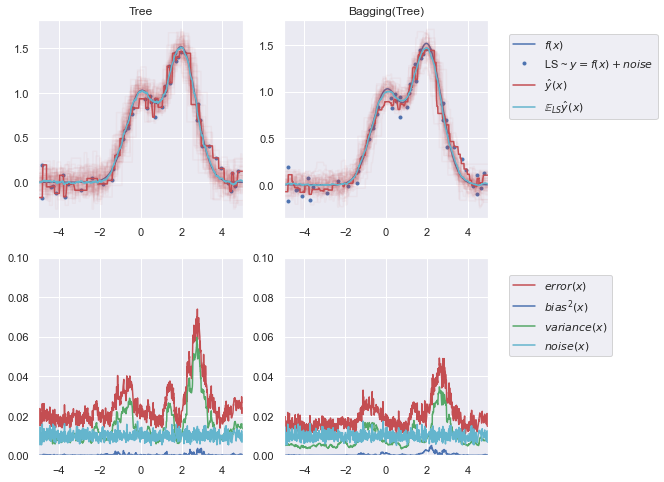

In [13]:
# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor(), n_estimators=10)),
]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

Постройте графики зависимости Bias, Variance и Неустранимого шума от глубины деревьев
Сравните графики для единичного дерева и беггинга. Сделайте выводы и объясните их.

_Если сможете найти все предусмотренные выводы и дадите полное описание, сможете получить бонусные баллы (+5%)_

In [44]:
#results = list()

n_max_depth = 12

n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

mean_result = np.empty(0)
for k in tqdm(range(1, n_max_depth)):
    estimators = [
        ("Tree", DecisionTreeRegressor(max_depth = k)),
        ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor(max_depth = k), n_estimators=10)),
    ]
    for n, (name, estimator) in enumerate(estimators):
        #print (f'{k} {n} {name} {estimator}')
        y_predict = np.zeros((n_test, n_repeat))

        for i in range(n_repeat):
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
        y_error = np.zeros(n_test)

        for i in range(n_repeat):
            for j in range(n_repeat):
                y_error += (y_test[:, j] - y_predict[:, i]) ** 2

        y_error /= n_repeat * n_repeat

        y_noise = np.var(y_test, axis=1)
        y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
        y_var = np.var(y_predict, axis=1)
        mean_result = np.append(mean_result, 
                                [n, k, np.mean(y_var), np.mean(y_bias), 
                                 np.mean(y_error), np.mean(y_noise)])

100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.69it/s]


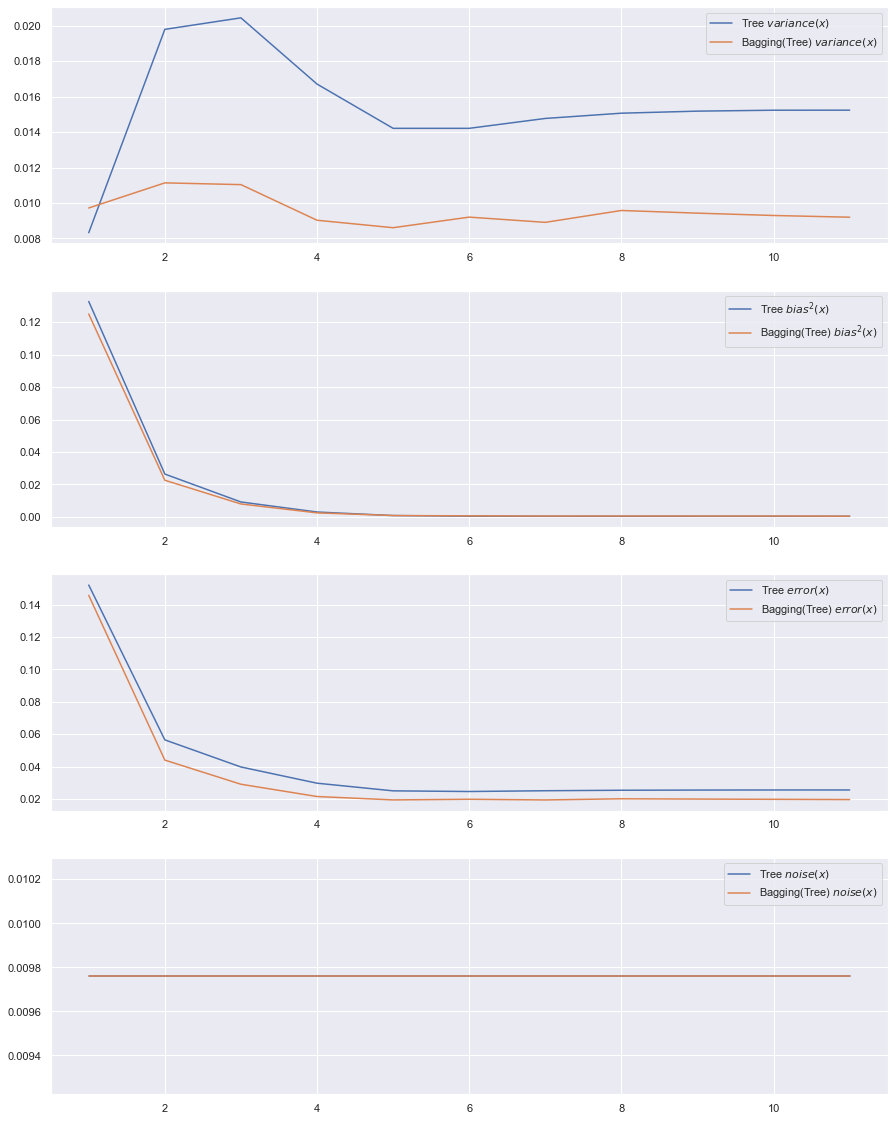

In [45]:
plot_labels = ["$variance(x)$", "$bias^2(x)$", "$error(x)$", "$noise(x)$"]

mv = mean_result.reshape(-1, 6)
x_args = mv[mv[:, 0]==0][:,1]

fig, axs = plt.subplots(4, 1, figsize=(15,20))
for i in range(4):
    for est in range(2):
        sns.lineplot(x=x_args, y = mv[mv[:, 0]==est][:,i+2], ax=axs[i], 
                     label = estimators[est][0] + ' ' + plot_labels[i]) 


1. Variance - среднее значение дисперсии у bagging tree ниже чем у простого дерева(следует из теории - мы как раз уменьшаем дисперсию) но при увеличении сложности модели оно не достигает нуля. Даже при не глубоких деревьях дисперсия для bagging низкая, мы усредняем метрику. При увеличении глубины дерева до 6 дисперсия достигает оптимального значения у обычных деревьев и после этого начинает немного увеличиваться на тестовой выборке, что опять же следует из теории bias-variance tradeoff. Для bagging, при достижении определенного значения глубины дисперсия не меняется - модели усредняем на неглубоких деревьях. Variance у бэггинга кратно(соответствует количеству деревьев в бэггинге) меньше чем у обычных деревьям.
2. Bias - и у бэггинга и у обычных деревьев на "пнях" большой - следует из разложения на bias - он высокий у слабых моделей. Смещение у бэггинга и обычных деревьев почти не отличается, при аггрегации моделей смещение не зависит от аггрегации.
3. Неустранимая ошибка - константа для всех методов и глубин деревьев - она не зависит от самой модели и является характерисикой задачи и очень близка к заданному показателю 0.1

# Задание 3 - OOB (10%)

Повторим то, что мы обсуждали на лекции:
На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, значит:  
Вероятность, что объект попадет в выборку: $ \frac{1}{l}$ (где $l$ количество объектов в датасете), а значит вероятность, что объект не попадет в выборку: $ 1-\frac {1}{l}$    
  
Так как мы тянем $l$ раз, то  вероятность, что объект не попадет во всю выборку: $ \bigl( 1-\frac {1}{l} \bigr) ^l$

Значит, при  $l \rightarrow \infty$ вероятность, что объект не попадает в выборку: $ \frac {1}{e} \approx 0.37 $      
  
__Вывод:__ При формировании Bootstrap выборки в нее попадает только __63%__ объектов   
__Свойство:__ Можно вычислять Out-of-bag error и не проводить кросс валидацию

В этом задании, предлагается проверить, не обманываю ли я вас, на конкретном примере.

Загрузим данные с нашего семинара и сделаем все предобработки.

In [4]:
# Загрузим данные и проведем предобработки:
data = pd.read_csv('flight_delays_train.csv')

data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')
data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

# DepTime пусть бдет более вещественным числом (так как 60 минут в часах)
data['DepTime_real'] = data['DepTime'].apply(lambda x: int(x/100)+((x/100-int(x/100))*100)/59)
data.drop('DepTime', axis=1, inplace=True)


x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values

data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_real
0,8,21,7,0,0,0,732,0,19.576271
1,4,20,3,1,1,1,834,0,15.813559
2,9,2,5,2,2,2,416,0,14.372881
3,11,25,6,3,3,3,872,0,10.254237
4,10,7,6,4,4,4,423,1,18.474576


1. Сначала сделайте кроссвалидацию с `RandomForestClassifier` на 100 деревьев, а в качестве максимального кол-ва фичей для сплита еспользуйте формулу $\sqrt{n}$. Подумайте, сколько нужно фолдов, чтобы это соответствовало OOB.
В качестве метрик, используйте `accuracy` и `roc_auc`
2. Затем обучите RandomForestClassifier на всей выборке `x, y`, но с включенным `oob_score`, посчитайте и сравните `accuracy` и `roc_auc` на OOB, с полученными метриками на кроссвалидации
3. Сравните, во сколько раз быстрее время обучения. Объясните почему.

In [22]:
%%time
rf_clf = RandomForestClassifier(random_state = 42, max_features='sqrt', 
                                n_estimators = 100, n_jobs=-1)

kf = KFold(n_splits = 3, random_state=42, shuffle = True) # нам нужно 3 фолда
cross_val_scores = cross_validate(rf_clf, x, y, cv=kf, scoring=["roc_auc", "accuracy"])

print (f'Accuracy score {cross_val_scores["test_accuracy"].mean():.4f}, ROC AUC {cross_val_scores["test_roc_auc"].mean():.4f}')


Accuracy score 0.8185, ROC AUC 0.7259
CPU times: user 28 s, sys: 433 ms, total: 28.4 s
Wall time: 4.56 s


In [23]:
%%time
rf_oob_clf = RandomForestClassifier(random_state = 42, max_features='sqrt', 
                                    n_estimators = 100, n_jobs = -1, oob_score = True)
rf_oob_clf.fit(x, y)

roc_auc_oob = roc_auc_score(y, rf_oob_clf.oob_decision_function_[:,1])

print (f'Accuracy score OOB {rf_oob_clf.oob_score_:.4f}, ROC AUC OOB {roc_auc_oob:.4f}')

Accuracy score OOB 0.8182, ROC AUC OOB 0.7225
CPU times: user 12.9 s, sys: 279 ms, total: 13.2 s
Wall time: 2.79 s


При кроссвалидации на фолдах алгоритм несколько раз проходит по выборкам для работы на обучения на одной группе фолдов и тестировании на другой. При оценке OOB - мы делаем обучение на бутстраповой выборке - 67% данных и оценку делаем на OOB, многократного похождения не нужно. 

# Задание 4 (60%)

Разделите обучающую выборку (`data`) из предыдущего задания на обучающую и отложенную в соотношении 70% / 30%

### Бонусные баллы (+10%)
Посчитайте баланс классов. Одинаковый ли баланс классов получился при разделении? 😉
Достаточно ли элегантно ваше решение?
Если классы окажутся несбалансированными может ли это повлиять на решение? Ответ объясните. Если повлияет, то предложите подход (и используйте его в последующих заданиях, можете заодно проверить, приносит ли он пользу)

In [26]:
def get_class_balance(y: np.array) -> np.array :
    list_len = len(y)
    return np.around(
        np.array([len(y[y == 0])/list_len, len(y[y == 1])/list_len], 
                 dtype=float),
        decimals = 6)

X_train, X_hold_out, y_train, y_hold_out = train_test_split(x, y, shuffle=True, test_size=0.3, stratify = y)

print (f'''Original class balance {get_class_balance(y)} 
Train class balance {get_class_balance(y_train)}, 
Hold-out class balance {get_class_balance(y_hold_out)}''')


Original class balance [0.80956 0.19044] 
Train class balance [0.809557 0.190443], 
Hold-out class balance [0.809567 0.190433]


## 4.1. BaggingClassifier (15%)
Задайте несколько значений параметров `max_samples`, `max_features`, `bootstrap` и `n_estimators` подберите оптимальный набор параметров для BaggingClassifier c базовым классификатором DecisionTreeClassifier на 5-фолдовой кросс валидации. Для воспроизводимости зафиксируйте random_state, например, `random_state = 42`.

Для поиска оптимального набора параметров используйте [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

__*Внимание*__: не используйте отложенную выборку

In [320]:
%%time
base_clf = DecisionTreeClassifier(max_depth=10)
bagging_clf = BaggingClassifier(base_clf, random_state = 42,)
params_grid = {
    'max_samples': np.linspace(0.5, 1., 5), 
    'max_features': np.linspace(0.5, 1., 5),
    'bootstrap': [True, False],
    'n_estimators': np.linspace(50, 200, 5, dtype = int),
}

grid_cv_bagging = GridSearchCV(bagging_clf, params_grid, scoring='accuracy', cv = 5, verbose = 2)
grid_cv_bagging.fit(X_train, y_train)
joblib.dump(grid_cv_bagging, 'grid_cv_bagging_2.joblib')

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=87; total time=   2.9s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=87; total time=   2.9s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=87; total time=   2.9s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators=87; total time=   2.9s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.5, n_estimators

[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=87; total time=   4.0s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=125; total time=   5.8s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=125; total time=   6.0s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=125; total time=   5.8s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=125; total time=   5.8s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=125; total time=   5.8s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=162; total time=   7.6s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=162; total time=   7.6s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=162; total time=   7.6s
[CV] END bootstrap=True, max_features=0.5, max_samples=0.875, n_estimators=162; total time=   7.6s
[CV] END bo

[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=162; total time=   7.8s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=162; total time=   7.7s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=200; total time=   9.6s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=200; total time=   9.6s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=200; total time=   9.6s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=200; total time=   9.6s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.625, n_estimators=200; total time=   9.8s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.75, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.75, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_features=0.625, max_samples=0.75, n_estimators=50; total time=   2

[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=87; total time=   4.4s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=87; total time=   4.4s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=87; total time=   4.4s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=87; total time=   4.3s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.5, n_estimators=125; total time=   6.2s
[CV] END bootstrap=True, max_

[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=125; total time=   8.8s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=125; total time=   8.8s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=125; total time=   8.8s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=125; total time=   8.8s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=125; total time=   8.8s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=162; total time=  11.4s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=162; total time=  11.7s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=162; total time=  11.5s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=162; total time=  11.4s
[CV] END bootstrap=True, max_features=0.75, max_samples=0.875, n_estimators=162; total time=  11.4s


[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=162; total time=  10.9s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=162; total time=  10.8s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=200; total time=  13.4s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=200; total time=  13.4s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=200; total time=  13.4s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=200; total time=  13.6s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.625, n_estimators=200; total time=  13.4s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.75, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.75, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_features=0.875, max_samples=0.75, n_estimators=50; total time=   3

[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=87; total time=   5.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=87; total time=   5.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=87; total time=   5.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=87; total time=   5.8s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=87; total time=   5.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.5, n_estimators=125; total time=   8.3s
[CV] END bootstrap=True, max_features=1

[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=125; total time=  11.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=125; total time=  11.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=125; total time=  11.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=125; total time=  11.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=125; total time=  11.7s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=162; total time=  15.2s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=162; total time=  15.2s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=162; total time=  15.2s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=162; total time=  15.4s
[CV] END bootstrap=True, max_features=1.0, max_samples=0.875, n_estimators=162; total time=  15.2s
[CV] END b

[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=162; total time=   8.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=200; total time=  10.0s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=200; total time=  10.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=200; total time=  10.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=200; total time=  10.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.625, n_estimators=200; total time=  10.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=50; total time=   3.1s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=50; total time=   3.0s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=50; total time=   2.9s
[CV] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=50; total time=   2.9s
[CV] END

[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=87; total time=   4.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=125; total time=   6.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.5, n_estimators=125; total time=   6.5s
[CV] END

[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=87; total time=   7.3s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=125; total time=  10.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=125; total time=  10.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=125; total time=  10.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=125; total time=  10.5s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=125; total time=  10.6s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=162; total time=  13.7s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=162; total time=  13.8s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=162; total time=  13.7s
[CV] END bootstrap=False, max_features=0.625, max_samples=0.875, n_estimators=162; 

[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=162; total time=  12.2s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=162; total time=  12.3s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=162; total time=  12.2s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=200; total time=  15.0s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=200; total time=  15.1s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=200; total time=  15.1s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=200; total time=  15.1s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.625, n_estimators=200; total time=  15.0s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.75, n_estimators=50; total time=   4.5s
[CV] END bootstrap=False, max_features=0.75, max_samples=0.75, n_estimators=50; total time=  

[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=87; total time=   6.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=87; total time=   6.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=87; total time=   6.4s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=87; total time=   6.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.5, n_estimators=87; total time=   6.3s
[CV] END b

[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=87; total time=  10.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=87; total time=  10.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=87; total time=  10.3s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=125; total time=  14.7s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=125; total time=  14.9s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=125; total time=  14.8s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=125; total time=  14.8s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=125; total time=  14.8s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=162; total time=  19.2s
[CV] END bootstrap=False, max_features=0.875, max_samples=0.875, n_estimators=162; to

[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=162; total time=  16.5s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=162; total time=  16.3s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=162; total time=  16.3s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=162; total time=  16.3s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=162; total time=  16.2s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=200; total time=  20.1s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=200; total time=  20.1s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=200; total time=  20.1s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=200; total time=  20.2s
[CV] END bootstrap=False, max_features=1.0, max_samples=0.625, n_estimators=200; total time=  20.0s


[CV] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=200; total time=  30.4s
[CV] END bootstrap=False, max_features=1.0, max_samples=1.0, n_estimators=200; total time=  30.4s
CPU times: user 3h 17min 11s, sys: 29.5 s, total: 3h 17min 41s
Wall time: 3h 17min 55s


['grid_cv_bagging_2.joblib']

In [321]:
grid_cv_bagging.best_params_

{'bootstrap': False,
 'max_features': 0.875,
 'max_samples': 0.75,
 'n_estimators': 162}

## 4.2 RandomForestClassifier (15%)
Задайте несколько значений параметров  `n_estimators`, `min_samples_leaf`, `max_features`, `bootstrap` и `max_depth`
Проделайте те же шаги для RandomForestClassifier, что требовалось сделать для BaggingClassifier. Не забудьте зафикисровать какое-нибудь значение random_state для воспроизводимости.

Для поиска оптимального набора параметров используйте [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

__*Внимание*__: не используйте отложенную выборку

In [28]:
%%time
base_rf_clf = RandomForestClassifier(random_state = 42, n_jobs = -1)
params_grid = {
    'min_samples_leaf': np.linspace(2, 12, 5, dtype = int), 
    'max_features': np.linspace(0.1, 1., 5),
    'bootstrap': [True, False],
    'max_depth': np.linspace(5, 20, 7, dtype = int),
    'n_estimators': np.linspace(10, 100, 5, dtype = int),
}
grid_random = RandomizedSearchCV(base_rf_clf, params_grid, random_state = 42, 
                                 cv=5, scoring = 'accuracy', verbose = 2)
grid_random.fit(X_train, y_train)
joblib.dump(grid_random, 'grid_rf.joblib')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=10, max_features=0.1, min_samples_leaf=2, n_estimators=32; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=0.1, min_samples_leaf=2, n_estimators=32; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=0.1, min_samples_leaf=2, n_estimators=32; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=0.1, min_samples_leaf=2, n_estimators=32; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=0.1, min_samples_leaf=2, n_estimators=32; total time=   0.2s
[CV] END bootstrap=False, max_depth=15, max_features=0.775, min_samples_leaf=4, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=15, max_features=0.775, min_samples_leaf=4, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=15, max_features=0.775, min_samples_leaf=4, n_estimators=100; total time=   2.8s
[CV] END bootstrap

['grid_rf.joblib']

In [29]:
grid_random.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 12,
 'max_features': 0.775,
 'max_depth': 20,
 'bootstrap': False}

## 4.3 AdaBoostClassifier (15%)
Проверните тоже самое для подбора пары `n_estimators`, `learning_rate` для AdaBoostClassifier. В качестве базового классификатора используйте DecisionTreeClassifier. Подьерите также глубину деревьев

__*Внимание*__: не используйте отложенную выборку

In [127]:
base_ada_clf = DecisionTreeClassifier(max_depth=2)# Для AdaBoost выбираем глубину дерева 2
params_grid = {
    'learning_rate': np.linspace(0.3, 2.0, 20),
    'n_estimators': np.linspace(50, 200, 5, dtype = int),
}
ada_clf = AdaBoostClassifier(base_ada_clf, random_state = 42, algorithm = 'SAMME') 
grid_adaboost = GridSearchCV(ada_clf, params_grid, scoring='accuracy', cv=5, verbose = 2)
grid_adaboost.fit(X_train, y_train)
joblib.dump(ada_clf, 'grid_adaboost_2.joblib')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   1.6s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   1.5s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   1.5s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   1.6s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   1.5s
[CV] END .................learning_rate=0.3, n_estimators=87; total time=   2.6s
[CV] END .................learning_rate=0.3, n_estimators=87; total time=   2.6s
[CV] END .................learning_rate=0.3, n_estimators=87; total time=   2.7s
[CV] END .................learning_rate=0.3, n_estimators=87; total time=   2.7s
[CV] END .................learning_rate=0.3, n_estimators=87; total time=   2.7s
[CV] END ................learning_rate=0.3, n_estimators=125; total time=   3.8s
[CV] END ................learning_rate=0.3, n_

['grid_adaboost_2.joblib']

[CV] END ...learning_rate=1.731578947368421, n_estimators=87; total time=   3.0s
[CV] END ...learning_rate=1.731578947368421, n_estimators=87; total time=   3.0s
[CV] END ...learning_rate=1.731578947368421, n_estimators=87; total time=   3.0s
[CV] END ..learning_rate=1.731578947368421, n_estimators=125; total time=   4.3s
[CV] END ..learning_rate=1.731578947368421, n_estimators=125; total time=   4.4s
[CV] END ..learning_rate=1.731578947368421, n_estimators=125; total time=   4.3s
[CV] END ..learning_rate=1.731578947368421, n_estimators=125; total time=   4.3s
[CV] END ..learning_rate=1.731578947368421, n_estimators=125; total time=   4.3s
[CV] END ..learning_rate=1.731578947368421, n_estimators=162; total time=   5.8s
[CV] END ..learning_rate=1.731578947368421, n_estimators=162; total time=   5.6s
[CV] END ..learning_rate=1.731578947368421, n_estimators=162; total time=   5.6s
[CV] END ..learning_rate=1.731578947368421, n_estimators=162; total time=   5.6s
[CV] END ..learning_rate=1.7

NameError: name 'grid_cv_bagging' is not defined

In [6]:
grid_adaboost.best_params_

{'learning_rate': 1.6421052631578947, 'n_estimators': 162}

## 4.4 Сравнение, блендинг и стекинг (15%)

На полученной после разделения обучающей выборке:
- Обучите bagging с оптимальными параметрами из пункта 4.1
- Обучите случайный лес с оптимальными параметрами из пункта 4.2
- Обучите boosting с оптимальными параметрами из пункта 4.3

In [30]:
best_base_clf = DecisionTreeClassifier(max_depth=10)
best_bagging_clf = BaggingClassifier(best_base_clf, random_state = 42,
                               bootstrap = False, 
                               max_features = 0.875, 
                               max_samples = 0.75, 
                               n_estimators = 162)
best_bagging_clf.fit(X_train, y_train)

best_rf_clf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                                    n_estimators = 100,
                                    min_samples_leaf = 12,
                                    max_features = 0.775,
                                    max_depth = 20, 
                                    bootstrap = False)
best_rf_clf.fit(X_train, y_train)

best_base_ada_clf = DecisionTreeClassifier(max_depth=2)
best_ada_clf = AdaBoostClassifier(best_base_ada_clf, random_state = 42,
                                 learning_rate = 1.6421, 
                                 n_estimators = 162,
                                 algorithm = 'SAMME')
best_ada_clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.6421, n_estimators=162, random_state=42)

Примените каждый алгоритм на отложенной выборке и посчитайте `roc_auc`, сравните результаты

In [40]:
bagging_prediction = best_bagging_clf.predict_proba(X_hold_out)[:,1]
rf_prediction = best_rf_clf.predict_proba(X_hold_out)[:,1]
ada_prediction = best_ada_clf.predict_proba(X_hold_out)[:,1]

roc_auc_bagging = roc_auc_score(y_hold_out, bagging_prediction)
roc_auc_rf = roc_auc_score(y_hold_out, rf_prediction)
roc_auc_ada = roc_auc_score(y_hold_out, ada_prediction)
print (f'ROC AUC Bagging {roc_auc_bagging}\nROC AUC RandomForest {roc_auc_rf}\nROC AUC AdaBoost {roc_auc_ada}')

ROC AUC Bagging 0.7251338184269704
ROC AUC RandomForest 0.7215578568586339
ROC AUC AdaBoost 0.7206608619973628


Смешайте предсказания всех трех алгоритмов:
- Сначала используйте просто взвешенное среднее
- Попробуйте подобрать веса, для улучшения результата

In [75]:

avg_predictions = (bagging_prediction + rf_prediction + ada_prediction)/3

roc_auc_avg = roc_auc_score(y_hold_out, avg_predictions)

print(f'ROC AUC Mean {roc_auc_avg:.4f}')

def f(w):
    return -roc_auc_score(y_hold_out, w[0]*bagging_prediction + w[1]*rf_prediction + (1 - w[0] - w[1])*ada_prediction)

optimze = minimize(f, [0.1, 0.1], method='Nelder-Mead')
w_bag, w_rf = optimze.x
w_ada = 1 - w_bag - w_rf
roc_auc_w = roc_auc_score(y_hold_out, w_bag*bagging_prediction + w_rf*rf_prediction + w_ada*ada_prediction)

print (f'ROC AUC Weighted {roc_auc_w}')
print (f'Bagging weight {w_bag:.4f} Random forest weight {w_rf:.4f}, AdaBoost weight {w_ada:.4f}')

ROC AUC Mean 0.7298
ROC AUC Weighted 0.7332565553769959
Bagging weight 0.0844 Random forest weight 0.1074, AdaBoost weight 0.8081


Улучшение метрики ROC AUC получилось при весах Bagging weight 0.0844 Random forest weight 0.1074, AdaBoost weight 0.8081

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA